<a href="https://colab.research.google.com/github/Salma-Jamal/Neural-Machine-Translation/blob/main/Model/Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation 
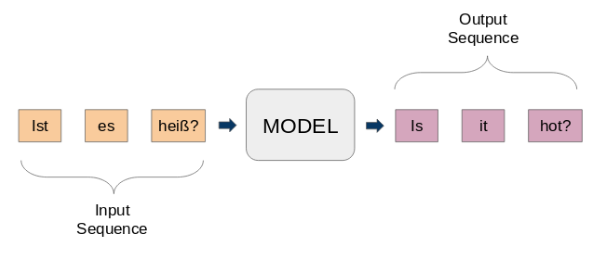

### Import Required Libraries

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt

#### Download Data

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown 1Jt5s-oexY1IfGTVrPBGok-QGTWSEsj8n

Downloading...
From: https://drive.google.com/uc?id=1Jt5s-oexY1IfGTVrPBGok-QGTWSEsj8n
To: /content/English-German.csv
100% 7.33M/7.33M [00:00<00:00, 20.5MB/s]


### Read Data

In [ ]:
df = pd.read_csv("/content/English-German.csv")

In [ ]:
df

,English Sentence,German Sentence
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!
...,...,...
138169,Carbon monoxide poisoning can cause hallucinat...,Eine Kohlenmonoxidvergiftung kann Halluzinatio...
138170,Even intelligent people are sometimes absent-m...,Sogar intelligente Menschen sind manchmal geis...
138171,Tom's great-great-great grandmother lived in S...,Toms Altgroßmutter lebte in Schottland.
138172,Tom's great-great-great grandmother lived in S...,Toms Urururgroßmutter lebte in Schottland.


In [ ]:
len(df)

138174

In [ ]:
df = df[:50000]

### Text Pre-Processing

#### Text Cleaning

We will get rid of the punctuation marks, and then convert the text to lower case.

In [ ]:
def remove_punct_lower(text):
  cleaned = text.translate(str.maketrans('', '', string.punctuation)).lower()
  return cleaned

In [ ]:
df['English Sentence'] = df['English Sentence'].apply(remove_punct_lower)
df['German Sentence'] = df['German Sentence'].apply(remove_punct_lower)

In [ ]:
df.head()

,English Sentence,German Sentence
0,go,geh
1,hi,hallo
2,hi,grüß gott
3,run,lauf
4,run,lauf


#### Text to Sequence Encoding

To feed our data in a Seq2Seq model, we have to:
- convert both the input and the output sentences into integer sequences of fixed length.

In [ ]:
df['English Sentence length'] = df['English Sentence'].map(lambda i: len(i.split()))
df['German Sentence length'] = df['German Sentence'].map(lambda i: len(i.split()))

In [ ]:
df.head()

,English Sentence,German Sentence,English Sentence length,German Sentence length
0,go,geh,1,1
1,hi,hallo,1,1
2,hi,grüß gott,1,2
3,run,lauf,1,1
4,run,lauf,1,1


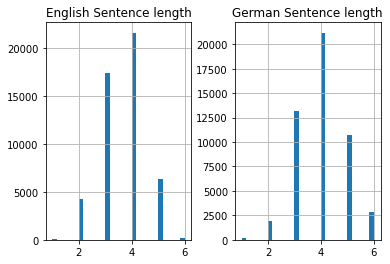

In [ ]:
df[['English Sentence length','German Sentence length']].hist(bins = 30)
plt.show()

In [ ]:
df['English Sentence length'].max()

6

In [ ]:
df['German Sentence length'].max()

6

In [ ]:
eng_length = 6
deu_length = 6

The maximum length of the German and English sentences is 6.

Vectorize the text data:
- Turn sentences into sequences of integers.
- Pad those sequences with zeros to make all the sequences of same length.

In [ ]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

Prepare English tokenizer

In [ ]:
eng_tokenizer = tokenization(df['English Sentence'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6132


Prepare German tokenizer

In [ ]:
deu_tokenizer = tokenization(df['German Sentence'])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10037


Function to prepare the sequences:
- Convert text into vectors.
- Pad sequence.

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values , padding='post', padding is added to the end of the sequence
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state = 12)

In [ ]:
train

,English Sentence,German Sentence,English Sentence length,German Sentence length
35235,tom wants to watch,tom will zusehen,4,3
36936,are you coming tom,kommst du tom,4,3
46486,i dont feel so well,ich fühle mich nicht so gut,5,6
27160,tom has been shot,tom ist erschossen worden,4,4
19490,mail this letter,sende diesen brief,3,3
...,...,...,...,...
36482,you have the floor,sie haben das wort,4,4
40177,it was just a guess,das war nur eine schätzung,5,5
19709,please be honest,sei bitte ehrlich,3,3
38555,i dont go out much,ich gehe nicht oft aus,5,5


It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train['German Sentence'])
trainY = encode_sequences(eng_tokenizer, eng_length, train['English Sentence'])

In [ ]:
# prepare test data
testX = encode_sequences(deu_tokenizer, deu_length, test['German Sentence'])
testY = encode_sequences(eng_tokenizer, eng_length, test['English Sentence'])

Define the Seq2Seq model architecture: 
- Encoder: Embedding layer and an LSTM layer 
- Decoder: LSTM layer followed by a Dense layer.

In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    '''
    in_vocab:  the size of the input vocabulary (German Vocab size)
    out_vocab: the size of the output vocabulary (English Vocab size)
    in_timesteps: the length of the input sequence (6)
    out_timesteps: the length of the output sequence (6)
    units: the number of units in the LSTM layers of the model

    '''
    # create a new sequential model
    model = Sequential()

    # convert the input sequence into a dense vector representation 
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) # input shape (batch size,6) => (batch size,6,512)

    # process the embedded input sequence and extract features that can be used to generate the output sequence
    model.add(LSTM(units)) # (output shape => (None,512))

    model.add(RepeatVector(out_timesteps)) # (output shape => (None,6,512))

    # Processes the repeated output from the previous layer and generates a sequence of output vectors
    model.add(LSTM(units, return_sequences=True)) # (output shape => (None,6,512))

    # Generate a probability distribution over the output vocabulary for each element in the output sequence
    model.add(Dense(out_vocab, activation='softmax')) # (output shape => (None,6,vocab size))

    return model

In [ ]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 512)            5138944   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 6, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 6, 512)            2099200   
                                                                 
 dense (Dense)               (None, 6, 6132)           3145716   
                                                                 
Total params: 12,483,060
Trainable params: 12,483,060
Non-trainable params: 0
____________________________________________

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss.

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [ ]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'ModelWeights.12_Mar_23'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# reshaping trainY to match the shape of the output of the last layer of the model, which has shape (batch_size, out_timesteps, out_vocab)
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
62/63 [============================>.] - ETA: 0s - loss: 4.2328
Epoch 1: val_loss improved from inf to 3.64462, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 29s 304ms/step - loss: 4.2275 - val_loss: 3.6446
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 3.5560
Epoch 2: val_loss improved from 3.64462 to 3.58001, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 258ms/step - loss: 3.5560 - val_loss: 3.5800
Epoch 3/30
62/63 [============================>.] - ETA: 0s - loss: 3.3285
Epoch 3: val_loss improved from 3.58001 to 3.28211, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 262ms/step - loss: 3.3267 - val_loss: 3.2821
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 3.0968
Epoch 4: val_loss improved from 3.28211 to 3.10131, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 261ms/step - loss: 3.0968 - val_loss: 3.1013
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.9193
Epoch 5: val_loss improved from 3.10131 to 2.96047, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 259ms/step - loss: 2.9193 - val_loss: 2.9605
Epoch 6/30
62/63 [============================>.] - ETA: 0s - loss: 2.7471
Epoch 6: val_loss improved from 2.96047 to 2.85676, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 254ms/step - loss: 2.7469 - val_loss: 2.8568
Epoch 7/30
62/63 [============================>.] - ETA: 0s - loss: 2.5803
Epoch 7: val_loss improved from 2.85676 to 2.70013, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 263ms/step - loss: 2.5792 - val_loss: 2.7001
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 2.4161
Epoch 8: val_loss improved from 2.70013 to 2.57784, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 17s 269ms/step - loss: 2.4161 - val_loss: 2.5778
Epoch 9/30
62/63 [============================>.] - ETA: 0s - loss: 2.2676
Epoch 9: val_loss improved from 2.57784 to 2.49146, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 253ms/step - loss: 2.2678 - val_loss: 2.4915
Epoch 10/30
62/63 [============================>.] - ETA: 0s - loss: 2.1285
Epoch 10: val_loss improved from 2.49146 to 2.37829, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 17s 270ms/step - loss: 2.1278 - val_loss: 2.3783
Epoch 11/30
62/63 [============================>.] - ETA: 0s - loss: 1.9947
Epoch 11: val_loss improved from 2.37829 to 2.29952, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 256ms/step - loss: 1.9951 - val_loss: 2.2995
Epoch 12/30
62/63 [============================>.] - ETA: 0s - loss: 1.8720
Epoch 12: val_loss improved from 2.29952 to 2.21078, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 264ms/step - loss: 1.8718 - val_loss: 2.2108
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.7535
Epoch 13: val_loss improved from 2.21078 to 2.14604, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 257ms/step - loss: 1.7535 - val_loss: 2.1460
Epoch 14/30
62/63 [============================>.] - ETA: 0s - loss: 1.6436
Epoch 14: val_loss improved from 2.14604 to 2.08266, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 264ms/step - loss: 1.6434 - val_loss: 2.0827
Epoch 15/30
62/63 [============================>.] - ETA: 0s - loss: 1.5389
Epoch 15: val_loss improved from 2.08266 to 2.02286, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 255ms/step - loss: 1.5386 - val_loss: 2.0229
Epoch 16/30
62/63 [============================>.] - ETA: 0s - loss: 1.4369
Epoch 16: val_loss improved from 2.02286 to 1.97782, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 17s 270ms/step - loss: 1.4367 - val_loss: 1.9778
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 1.3435
Epoch 17: val_loss improved from 1.97782 to 1.93192, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 255ms/step - loss: 1.3435 - val_loss: 1.9319
Epoch 18/30
62/63 [============================>.] - ETA: 0s - loss: 1.2519
Epoch 18: val_loss improved from 1.93192 to 1.89192, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 254ms/step - loss: 1.2515 - val_loss: 1.8919
Epoch 19/30
62/63 [============================>.] - ETA: 0s - loss: 1.1645
Epoch 19: val_loss improved from 1.89192 to 1.85954, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 265ms/step - loss: 1.1653 - val_loss: 1.8595
Epoch 20/30
62/63 [============================>.] - ETA: 0s - loss: 1.0820
Epoch 20: val_loss improved from 1.85954 to 1.81617, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 258ms/step - loss: 1.0824 - val_loss: 1.8162
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 1.0071
Epoch 21: val_loss improved from 1.81617 to 1.78430, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 263ms/step - loss: 1.0071 - val_loss: 1.7843
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.9315
Epoch 22: val_loss improved from 1.78430 to 1.75416, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 264ms/step - loss: 0.9315 - val_loss: 1.7542
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.8616
Epoch 23: val_loss improved from 1.75416 to 1.73961, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 17s 267ms/step - loss: 0.8616 - val_loss: 1.7396
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.7965
Epoch 24: val_loss improved from 1.73961 to 1.71490, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 254ms/step - loss: 0.7965 - val_loss: 1.7149
Epoch 25/30
62/63 [============================>.] - ETA: 0s - loss: 0.7351
Epoch 25: val_loss improved from 1.71490 to 1.69093, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 17s 270ms/step - loss: 0.7351 - val_loss: 1.6909
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.6791
Epoch 26: val_loss improved from 1.69093 to 1.67905, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 258ms/step - loss: 0.6791 - val_loss: 1.6790
Epoch 27/30
62/63 [============================>.] - ETA: 0s - loss: 0.6226
Epoch 27: val_loss did not improve from 1.67905
63/63 [==============================] - 3s 50ms/step - loss: 0.6228 - val_loss: 1.6827
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.5737
Epoch 28: val_loss improved from 1.67905 to 1.67153, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 16s 264ms/step - loss: 0.5737 - val_loss: 1.6715
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.5308
Epoch 29: val_loss improved from 1.67153 to 1.66543, saving model to ModelWeights.12_Mar_23


63/63 [==============================] - 17s 266ms/step - loss: 0.5308 - val_loss: 1.6654
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.4833
Epoch 30: val_loss did not improve from 1.66543
63/63 [==============================] - 3s 48ms/step - loss: 0.4833 - val_loss: 1.6782


Let's compare the training loss and the validation loss.

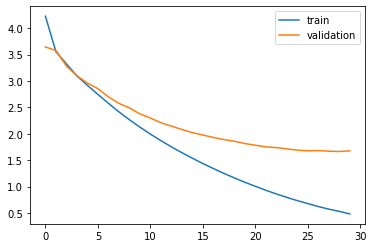

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [ ]:
!gdown 1rJEUSIIjU_nUZ5KkH3TtUIxk0XECPhRy

Downloading...
From: https://drive.google.com/uc?id=1rJEUSIIjU_nUZ5KkH3TtUIxk0XECPhRy
To: /content/ModelWeights.12_Mar_23.zip
100% 89.7M/89.7M [00:01<00:00, 45.0MB/s]


In [ ]:
!unzip /content/ModelWeights.12_Mar_23.zip

Archive:  /content/ModelWeights.12_Mar_23.zip
   creating: content/ModelWeights.12_Mar_23/
 extracting: content/ModelWeights.12_Mar_23/fingerprint.pb  
   creating: content/ModelWeights.12_Mar_23/assets/
   creating: content/ModelWeights.12_Mar_23/variables/
  inflating: content/ModelWeights.12_Mar_23/variables/variables.index  
  inflating: content/ModelWeights.12_Mar_23/variables/variables.data-00000-of-00001  
  inflating: content/ModelWeights.12_Mar_23/saved_model.pb  
  inflating: content/ModelWeights.12_Mar_23/keras_metadata.pb  


In [ ]:
model = load_model('/content/content/ModelWeights.12_Mar_23')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds = [np.argmax(i,axis=1) for i in preds]

313/313 [==============================] - 7s 5ms/step


In [ ]:
preds_text = eng_tokenizer.sequences_to_texts(preds)

In [ ]:
pred_df = pd.DataFrame({'actual' : test['English Sentence'], 'predicted' : preds_text})

In [ ]:
pred_df.head(15)

,actual,predicted
34622,tom is a true poet,tom is a a poet
1163,tom knows,tom knows
7637,tom phoned us,tom called us
7045,please listen,please please
43847,where have you been,where were you been
40867,please listen to us,please listen to
45653,have it your own way,do what you
42099,tom felt humiliated,tom felt flattered
17636,he wears glasses,he a glasses
42703,tom may leave early,tom can to wait
